Setting up the simulator

In [3]:
import pybullet as p
import pybullet_data
import time
import numpy as np
import tensorflow as tf
from tf_agents.policies import py_tf_eager_policy
import tensorflow_hub as hub
from tf_agents.trajectories import time_step as ts
import math
import pybullet_robots.panda.panda_sim as panda_sim

In [13]:
# Initialize PyBullet
# physicsClient = p.connect(p.GUI)
# p.setAdditionalSearchPath(pybullet_data.getDataPath())
# p.setGravity(0, 0, -10)

# # Load the environment
# planeId = p.loadURDF("plane.urdf")

# # Scale the table, cube, and robot
# tableScale = 1    # Table size
# cubeScale = 0.2   # Size of the cube
# robotScale = 2.0  # Size of the robot

# # Load the table
# tableId = p.loadURDF("table/table.urdf", basePosition=[1, 0, 0], globalScaling=tableScale)

# # Calculate the height at which the cube should be placed to be on top of the table
# cubeHeight = cubeScale * 0.5  # Half of the cube's height
# tableHeight = 1  # Assuming the table's height is 1 unit
# cubePositionHeight = tableHeight + cubeHeight

# # Load the cube on the table
# cubeId = p.loadURDF("cube.urdf", basePosition=[1, 0, cubePositionHeight], globalScaling=cubeScale)

# # Position and scale the robot
# startPos = [0, 0, 0]
# startOrientation = p.getQuaternionFromEuler([0, 0, 0])
# robotId = p.loadURDF("franka_panda/panda.urdf", startPos, startOrientation, globalScaling=robotScale)
import pybullet as p
import pybullet_data as pd
import time
import pybullet_robots.panda.panda_sim as panda_sim

physicsClient = p.connect(p.GUI)
p.configureDebugVisualizer(p.COV_ENABLE_Y_AXIS_UP, 1)
# p.configureDebugVisualizer(p.COV_ENABLE_GUI, 0)
p.setAdditionalSearchPath(pd.getDataPath())
p.setPhysicsEngineParameter(maxNumCmdPer1ms=1000)
p.resetDebugVisualizerCamera(cameraDistance=2, cameraYaw=38, cameraPitch=-22, cameraTargetPosition=[0.35, -0.13, 0])

timeStep = 1./60.
p.setTimeStep(timeStep)
p.setGravity(0, -9.8, 0)
 
panda = panda_sim.PandaSim(p, [0, 0, 0])

# Run the simulation for a specific number of steps
num_steps = 100  # for example, simulate for 1000 steps
for _ in range(num_steps):
    panda.step()
    p.stepSimulation()
    time.sleep(timeStep)

# Optionally, you can add some code here to save the state, or analyze the final positions of objects, etc.


Version = 4.1 Metal - 88
Vendor = Apple
Renderer = Apple M2 Pro
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started


Setting up virtual cameras for observation

In [4]:
# # Function to capture images
# import matplotlib.pyplot as plt
# def capture_image():
#     width, height = 224, 224
#     view_matrix = p.computeViewMatrixFromYawPitchRoll(cameraTargetPosition=[1, 0, 1],
#                                                       distance=1,
#                                                       yaw=0,
#                                                       pitch=-30,
#                                                       roll=0,
#                                                       upAxisIndex=2)
#     projection_matrix = p.computeProjectionMatrixFOV(fov=60, aspect=1.0,
#                                                      nearVal=0.1, farVal=100.0)
#     _, _, rgbImg, depthImg, _ = p.getCameraImage(width=width,
#                                                  height=height,
#                                                  viewMatrix=view_matrix,
#                                                  projectionMatrix=projection_matrix)
#     # dummy = np.reshape(rgbImg, (width, height, 3))
#     # print(dummy)
#     # return np.array(rgbImg), np.array(depthImg)
#     image = np.reshape(rgbImg, (width, height, 4))
#     imgplot = plt.imshow(image)
#     return np.reshape(rgbImg, (width, height, 4)), np.array(depthImg)
# import matplotlib.pyplot as plt
# def capture_image():
#     width, height = 224, 224
#     view_matrix = p.computeViewMatrixFromYawPitchRoll(cameraTargetPosition=[-0.35, -0.13, 0],
#                                                       distance=2,
#                                                       yaw=38,
#                                                       pitch=-22,
#                                                       roll=0,
#                                                       upAxisIndex=2)
#     projection_matrix = p.computeProjectionMatrixFOV(fov=60, aspect=1.0,
#                                                      nearVal=0.1, farVal=100.0)
#     _, _, rgbImg, depthImg, _ = p.getCameraImage(width=width,
#                                                  height=height,
#                                                  viewMatrix=view_matrix,
#                                                  projectionMatrix=projection_matrix)
#     image = np.reshape(rgbImg, (height, width, 4))[..., :3]
#     plt.imshow(image)
#     return image.astype(np.uint8), np.array(depthImg)
import matplotlib.pyplot as plt
def capture_image():
    width, height = 224, 224
    # Use the same camera target position, yaw, pitch, and roll as set in resetDebugVisualizerCamera
    camera_target_position = [0.35, -0.13, 0]  # Change as per the actual camera target used in your simulation
    camera_distance = 2
    camera_yaw = 38
    camera_pitch = -22

    view_matrix = p.computeViewMatrixFromYawPitchRoll(cameraTargetPosition=camera_target_position,
                                                      distance=camera_distance,
                                                      yaw=camera_yaw,
                                                      pitch=camera_pitch,
                                                      roll=0,
                                                      upAxisIndex=1)  # Ensure the upAxisIndex matches your simulation's configuration
    projection_matrix = p.computeProjectionMatrixFOV(fov=60, aspect=1.0,
                                                     nearVal=0.1, farVal=100.0)
    _, _, rgbImg, depthImg, _ = p.getCameraImage(width=width,
                                                 height=height,
                                                 viewMatrix=view_matrix,
                                                 projectionMatrix=projection_matrix)
    image = np.reshape(rgbImg, (height, width, 4))[..., :3]
    # plt.imshow(image)
    # plt.show() 
    return image.astype(np.uint8), np.array(depthImg)

# Now call capture_image to capture the scene
image, depth = capture_image()



array([0.99999988, 0.99999988, 0.99999988, ..., 0.99999988, 0.99999988,
       0.99999988])

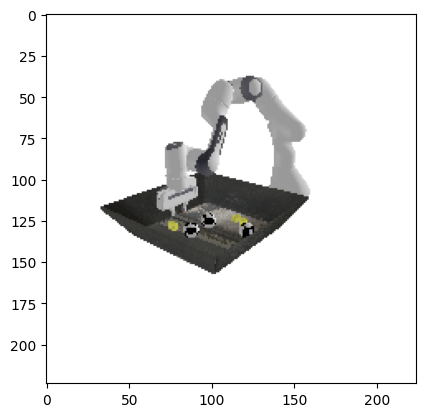

In [5]:
plt.imshow(image)
depth

In [6]:
#Preprocessed the observation
def preprocess_observation(rgbImg):
    processed_img = rgbImg / 255.0
    return processed_img

Load TF model checkpoints

In [7]:
# Load the pretrained model
saved_model_path = 'rt_1_x_tf_trained_for_002272480_step'
tfa_policy = py_tf_eager_policy.SavedModelPyTFEagerPolicy(
    model_path=saved_model_path,
    load_specs_from_pbtxt=True,
    use_tf_function=True)

***Load Language Instruction***

In [8]:
# Load language model for instructions embedding
embed = hub.load('https://tfhub.dev/google/universal-sentence-encoder-large/5')

In [9]:
def embed_instruction(instruction):
    normalized_instruction = instruction.replace('_', ' ')
    return embed([normalized_instruction])[0]

In [10]:
# def resize_image(image, new_width=320, new_height=256):
#     return tf.image.resize(image, [new_height, new_width])

def resize_image(image):
  image = tf.image.resize_with_pad(image, target_width=320, target_height=256)
  image = tf.cast(image, tf.uint8)
  return image

***Running the Simulation***

In [14]:
# Simulation loop
for i in range(10):
    rgbImg, depthImg = capture_image()
    print(rgbImg.size)
    processed_img = preprocess_observation(rgbImg)

    print(processed_img.shape)
    resized_img = resize_image(processed_img)

    # Define the task instruction
    instruction = "Pick the yellow item"
    instruction_embedding = embed_instruction(instruction)

    # Construct the observation to match the expected structure
    observation = {
        'image': resized_img,  # Make sure this is uint8 and shape (256, 320, 3)
        'natural_language_embedding': instruction_embedding,
        'natural_language_instruction': tf.constant([instruction])  # Ensure this matches expected type
    }

    # Initialize policy state if required by your model
    policy_state = {
        'action_tokens': tf.zeros([1, 15, 11, 1, 1], dtype=tf.int32),
        'context_image_tokens': tf.zeros([1, 15, 81, 1, 512], dtype=tf.float32),
        'seq_idx': tf.zeros([1, 1, 1, 1, 1], dtype=tf.int32)
    }

    # Obtain the action from the policy
    tfa_time_step = ts.transition(observation, reward=np.zeros((), dtype=np.float32))
    policy_step = tfa_policy.action(tfa_time_step, policy_state=policy_state)
    action = policy_step.action

    print(action)

    # Apply the action to the robot in the simulation as per your setup
    # e.g., p.setJointMotorControlArray(...) for joint actions

    p.stepSimulation()
    time.sleep(1./240.)

# p.disconnect()

150528
(224, 224, 3)
{'base_displacement_vector': array([-0.00195694, -0.00195694], dtype=float32), 'base_displacement_vertical_rotation': array([-0.00614786], dtype=float32), 'gripper_closedness_action': array([1.], dtype=float32), 'rotation_delta': array([-0.00307393, -0.00307393, -0.00307393], dtype=float32), 'terminate_episode': array([0, 1, 0], dtype=int32), 'world_vector': array([-0.00391388, -0.00391388, -0.00391388], dtype=float32)}
150528
(224, 224, 3)
{'base_displacement_vector': array([-0.00195694, -0.00195694], dtype=float32), 'base_displacement_vertical_rotation': array([-0.00614786], dtype=float32), 'gripper_closedness_action': array([1.], dtype=float32), 'rotation_delta': array([-0.00307393, -0.00307393, -0.00307393], dtype=float32), 'terminate_episode': array([0, 1, 0], dtype=int32), 'world_vector': array([-0.00391388, -0.00391388, -0.00391388], dtype=float32)}
150528
(224, 224, 3)
{'base_displacement_vector': array([-0.00195694, -0.00195694], dtype=float32), 'base_disp

: 